# Elo world 

In this kernel, I build a LGBM model that aggregates the `new_merchant_transactions.csv` and `historical_transactions.csv` tables to the main train table. New features are built by successive grouping on`card_id` and `month_lag`, in order to recover some information from the time serie.

During the competition, I took into account the enlightments provided by others kernels, and included a few features that appeared to be important. In particular, I closely looked at the following kernels (ordered by release time):
1.  [You're Going to Want More Categories [LB 3.737] by Peter Hurford](https://www.kaggle.com/peterhurford/you-re-going-to-want-more-categories-lb-3-737)
2. [EloDA with Feature Engineering and Stacking by Bojan Tunguz](https://www.kaggle.com/tunguz/eloda-with-feature-engineering-and-stacking)
3. [A Closer Look at Date Variables by Robin Denz](https://www.kaggle.com/denzo123/a-closer-look-at-date-variables)
4. [LGB + FE (LB 3.707) by Konrad Banachewicz](https://www.kaggle.com/konradb/lgb-fe-lb-3-707)
5. [My first kernel (3.699) by Chau Ngoc Huynh](https://www.kaggle.com/chauhuynh/my-first-kernel-3-699/)

## Notebook  Content
1. [Loading the data](#1)
1. [Feature engineering](#2)
1. [Training the model](#3)
1. [Feature importance](#4)
1. [Submission](#5)

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)

<a id="1"></a> <br>
## 1. Loading the data

First, we load the `new_merchant_transactions.csv` and `historical_transactions.csv`. In practice, these two files contain the same variables and the difference between the two tables only concern the position with respect to a reference date.  Also, booleans features are made numeric:

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
e = pd.read_excel('../input/Data_Dictionary.xlsx', sheet_name='train')
e

,train.csv,Unnamed: 1
0,NaN,NaN
1,Columns,Description
2,card_id,Unique card identifier
3,first_active_month,"'YYYY-MM', month of first purchase"
4,feature_1,Anonymized card categorical feature
5,feature_2,Anonymized card categorical feature
6,feature_3,Anonymized card categorical feature
7,target,Loyalty numerical score calculated 2 months af...


In [4]:
new_transactions = pd.read_csv('../input/new_merchant_transactions.csv',
                               parse_dates=['purchase_date'])

historical_transactions = pd.read_csv('../input/historical_transactions.csv',
                                      parse_dates=['purchase_date'])

def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df

historical_transactions = binarize(historical_transactions)
new_transactions = binarize(new_transactions)

We then load the main files, formatting the dates and extracting the target:

In [5]:
def read_data(input_file):
    df = pd.read_csv(input_file)
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['elapsed_time'] = (datetime.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days
    return df
#_________________________________________
train = read_data('../input/train.csv')
test = read_data('../input/test.csv')



In [6]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,elapsed_time
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,245
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,396
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,549
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,153
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,92


**EDA**

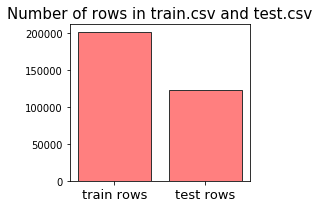

In [7]:
plt.figure(figsize=[4,3])
plt.bar([0, 1], [train.shape[0], test.shape[0]], edgecolor=[0.2]*3, color=(1,0,0,0.5))
plt.xticks([0,1], ['train rows', 'test rows'], fontsize=13)
plt.title('Number of rows in train.csv and test.csv', fontsize=15)
plt.tight_layout()
plt.show()

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 7 columns):
first_active_month    201917 non-null datetime64[ns]
card_id               201917 non-null object
feature_1             201917 non-null int64
feature_2             201917 non-null int64
feature_3             201917 non-null int64
target                201917 non-null float64
elapsed_time          201917 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 10.8+ MB


In [9]:
train.describe()

,feature_1,feature_2,feature_3,target,elapsed_time
count,201917.000000,201917.000000,201917.000000,201917.000000,201917.000000
mean,3.105311,1.745410,0.565569,-0.393636,381.978981
std,1.186160,0.751362,0.495683,3.850500,293.710176
min,1.000000,1.000000,0.000000,-33.219281,0.000000
25%,2.000000,1.000000,0.000000,-0.883110,153.000000
50%,3.000000,2.000000,1.000000,-0.023437,306.000000
75%,4.000000,2.000000,1.000000,0.765453,488.000000
max,5.000000,3.000000,1.000000,17.965068,2284.000000


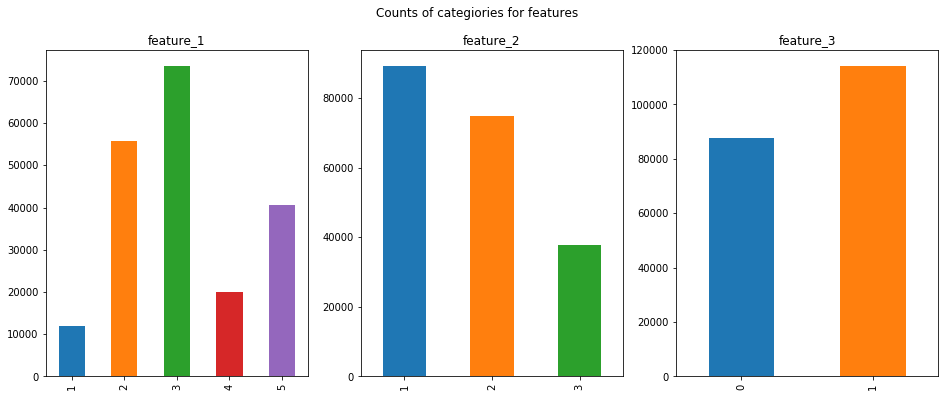

In [10]:
fig, ax = plt.subplots(1,3, figsize = (16, 6));
train['feature_1'].value_counts().sort_index().plot(kind='bar', ax=ax[0], title='feature_1');
train['feature_2'].value_counts().sort_index().plot(kind='bar', ax=ax[1], title='feature_2');
train['feature_3'].value_counts().sort_index().plot(kind='bar', ax=ax[2], title='feature_3');
plt.suptitle('Counts of categiories for features');

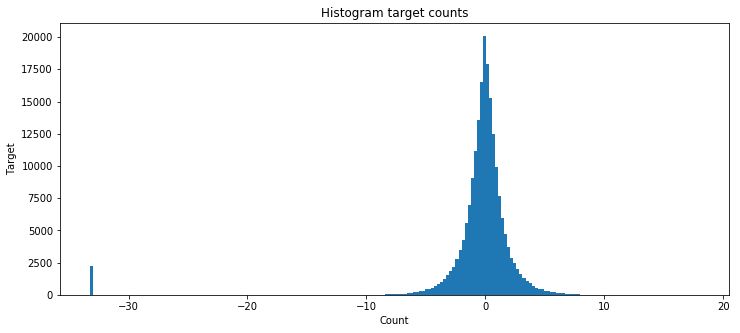

There are 2207 samples in the target equal to -33.21928095.


In [11]:
plt.figure(figsize=(12, 5))
plt.hist(train.target.values, bins=200)
plt.title('Histogram target counts')
plt.xlabel('Count')
plt.ylabel('Target')
plt.show()
print(f'There are {train.loc[train.target  == min(train.target)].shape[0]} samples in the target equal to {min(train.target)}.')

<a id="2"></a> <br>
## Feature engineering
Following [Chau Ngoc Huynh's kernel](https://www.kaggle.com/chauhuynh/my-first-kernel-3-699/), I add the following features:

In [12]:
e = pd.read_excel('../input/Data_Dictionary.xlsx', sheet_name='history')
e

,historical_transactions.csv,Unnamed: 1
0,NaN,NaN
1,Columns,Description
2,card_id,Card identifier
3,month_lag,month lag to reference date
4,purchase_date,Purchase date
5,authorized_flag,"Y' if approved, 'N' if denied"
6,category_3,anonymized category
7,installments,number of installments of purchase
8,category_1,anonymized category
9,merchant_category_id,Merchant category identifier (anonymized )


In [13]:
target = train['target']
del train['target']

In [14]:
datetime.datetime.today()
datetime.datetime(2018, 11, 27)

datetime.datetime(2018, 11, 27, 0, 0)

In [15]:
historical_transactions['month_diff'] = ((datetime.datetime(2018, 11, 27) - historical_transactions['purchase_date']).dt.days)//30
historical_transactions['month_diff'] += historical_transactions['month_lag']

new_transactions['month_diff'] = ((datetime.datetime(2018, 11, 27) - new_transactions['purchase_date']).dt.days)//30
new_transactions['month_diff'] += new_transactions['month_lag']

#hoidays source https://www.officeholidays.com/countries/brazil/2017 , https://www.officeholidays.com/countries/brazil/2018 
#including Christmas Eve, New Year's Eve and Black Awareness Day
holiday_dates = pd.to_datetime( ['01-01-2017','27-02-2017','28-02-2017','01-02-2017','14-04-2017','21-04-2017','01-05-2017','15-06-2017','07-09-2017',
                    '12-10-2017','01-11-2017','02-11-2017','15-11-2017','20-11-2017','24-12-2017','25-12-2017','31-12-2017',
                    '01-01-2018', '12-02-2018', '13-02-2018','30-03-2018','21-04-2018','01-05-2018','31-05-2018','07-09-2018',
                    '12-10-2018','02-11-2018','15-11-2018','20-11-2018','24-12-2018','25-12-2018','31-12-2018'] ,format="%d-%m-%Y")

historical_transactions["holiday_purchase"] = np.where(historical_transactions["purchase_date"].isin(holiday_dates) , 1, 0)
new_transactions["holiday_purchase"] = np.where(new_transactions["purchase_date"].isin(holiday_dates) , 1, 0)

In [16]:
new_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,month_diff,holiday_purchase
0,1,C_ID_415bb3a509,107,0,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19,9,0
1,1,C_ID_415bb3a509,140,0,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19,9,0
2,1,C_ID_415bb3a509,330,0,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14,9,0
3,1,C_ID_415bb3a509,-1,1,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8,9,0
4,1,C_ID_ef55cf8d4b,-1,1,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29,9,0


In [17]:
historical_transactions[:5]

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,month_diff,holiday_purchase
0,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37,9,0
1,1,C_ID_4e6213e9bc,88,0,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16,9,0
2,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37,9,0
3,1,C_ID_4e6213e9bc,88,0,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34,10,0
4,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37,9,0


In [18]:

#Convert categorical variable into dummy/indicator variables.
historical_transactions = pd.get_dummies(historical_transactions, columns=['category_2', 'category_3'])
new_transactions = pd.get_dummies(new_transactions, columns=['category_2', 'category_3'])


historical_transactions = reduce_mem_usage(historical_transactions)
new_transactions = reduce_mem_usage(new_transactions)


agg_fun = {'authorized_flag': ['mean']}
auth_mean = historical_transactions.groupby(['card_id']).agg(agg_fun)
auth_mean.columns = ['_'.join(col).strip() for col in auth_mean.columns.values]
auth_mean.reset_index(inplace=True)


authorized_transactions = historical_transactions[historical_transactions['authorized_flag'] == 1]
historical_transactions = historical_transactions[historical_transactions['authorized_flag'] == 0]

Mem. usage decreased to 1360.42 Mb (59.2% reduction)
Mem. usage decreased to 87.99 Mb (60.8% reduction)


In [19]:
historical_transactions[:5] 

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id,month_diff,holiday_purchase,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_A,category_3_B,category_3_C
115,0,C_ID_4e6213e9bc,88,0,0,842,M_ID_22c9cfa265,-10,-0.730379,2017-04-07 12:58:09,16,37,9,0,1,0,0,0,0,1,0,0
132,0,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-5,-0.723782,2017-09-17 22:40:27,16,16,9,0,1,0,0,0,0,1,0,0
148,0,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-5,-0.723782,2017-09-17 22:40:26,16,16,9,0,1,0,0,0,0,1,0,0
168,0,C_ID_4e6213e9bc,333,0,0,605,M_ID_c2ae34c2ef,0,-0.664262,2018-02-20 10:57:50,9,2,9,0,1,0,0,0,0,1,0,0
213,0,C_ID_4e6213e9bc,88,0,0,560,M_ID_e6d5ae8ea6,-7,-0.738132,2017-07-08 07:33:31,16,34,9,0,1,0,0,0,0,1,0,0


In [20]:
authorized_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id,month_diff,holiday_purchase,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_A,category_3_B,category_3_C
0,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,16,37,9,0,1,0,0,0,0,1,0,0
1,1,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,16,16,9,0,1,0,0,0,0,1,0,0
2,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,16,37,9,0,1,0,0,0,0,1,0,0
3,1,C_ID_4e6213e9bc,88,0,0,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,16,34,10,0,1,0,0,0,0,1,0,0
4,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,16,37,9,0,1,0,0,0,0,1,0,0


First, following [Robin Denz](https://www.kaggle.com/denzo123/a-closer-look-at-date-variables) analysis, I define a few dates features:

In [21]:
historical_transactions['purchase_month'] = historical_transactions['purchase_date'].dt.month
authorized_transactions['purchase_month'] = authorized_transactions['purchase_date'].dt.month
new_transactions['purchase_month'] = new_transactions['purchase_date'].dt.month

Then I define two functions that aggregate the info contained in these two tables. The first function aggregates the function by grouping on `card_id`:

In [22]:
def aggregate_transactions(history):
    
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
    'category_1': ['count','sum', 'mean'],
    'category_2_1.0': ['count','sum','mean'],
    'category_2_2.0': ['count','sum','mean'],
    'category_2_3.0': ['count','sum','mean'],
    'category_2_4.0': ['count','sum','mean'],
    'category_2_5.0': ['count','sum','mean'],
    'category_3_A': ['count','sum','mean'],
    'category_3_B': ['count','sum','mean'],
    'category_3_C': ['count','sum','mean'],
    'merchant_id': ['nunique'],
    'merchant_category_id': ['nunique'],
    'state_id': ['nunique'],
    'city_id': ['nunique'],
    'subsector_id': ['nunique'],
    'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
    'installments': ['sum', 'mean', 'max', 'min', 'std'],
    'purchase_month': ['mean', 'max', 'min', 'std'],
    'purchase_date': [np.ptp, 'min', 'max'],
    'month_lag': ['mean', 'max', 'min', 'std'],
    'month_diff': ['mean','max', 'min', 'std'],
    }
    
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history



In [23]:
history = aggregate_transactions(historical_transactions)
history.columns = ['hist_' + c if c != 'card_id' else c for c in history.columns]
history[:5]

,card_id,hist_transactions_count,hist_category_1_count,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_count,hist_category_2_1.0_sum,hist_category_2_1.0_mean,hist_category_2_2.0_count,hist_category_2_2.0_sum,hist_category_2_2.0_mean,hist_category_2_3.0_count,hist_category_2_3.0_sum,hist_category_2_3.0_mean,hist_category_2_4.0_count,hist_category_2_4.0_sum,hist_category_2_4.0_mean,hist_category_2_5.0_count,hist_category_2_5.0_sum,hist_category_2_5.0_mean,hist_category_3_A_count,hist_category_3_A_sum,hist_category_3_A_mean,hist_category_3_B_count,hist_category_3_B_sum,hist_category_3_B_mean,hist_category_3_C_count,hist_category_3_C_sum,hist_category_3_C_mean,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_city_id_nunique,hist_subsector_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_month_lag_mean,hist_month_lag_max,hist_month_lag_min,hist_month_lag_std,hist_month_diff_mean,hist_month_diff_max,hist_month_diff_min,hist_month_diff_std
0,C_ID_00007093c1,35,35,4.0,0.114286,35,0.0,0.000000,35,0,0.000000,35,31,0.885714,35,0.0,0.0,35,0.0,0.000000,35,0.0,0.000000,35,29.0,0.828571,35,6.0,0.171429,11,8,2,3,7,-14.401965,-0.411485,1.507069,-0.728876,0.430059,45,1.285714,3,1,0.667367,5.914286,12,1,3.071419,28858113.0,1.489250e+09,1.518108e+09,-6.028571,0,-11,3.535415,9.028571,10,9,0.169031
1,C_ID_0001238066,3,3,0.0,0.000000,3,1.0,0.333333,3,0,0.000000,3,0,0.000000,3,0.0,0.0,3,2.0,0.666667,3,0.0,0.000000,3,3.0,1.000000,3,0.0,0.000000,2,1,2,2,1,-1.789928,-0.596643,-0.596643,-0.596643,0.000000,3,1.000000,1,1,0.000000,8.666667,12,2,5.773503,3609150.0,1.514660e+09,1.518269e+09,-1.333333,0,-2,1.154701,9.000000,9,9,0.000000
2,C_ID_0001506ef0,4,4,0.0,0.000000,4,0.0,0.000000,4,0,0.000000,4,4,1.000000,4,0.0,0.0,4,0.0,0.000000,4,3.0,0.750000,4,1.0,0.250000,4,0.0,0.000000,4,4,1,1,4,-2.905782,-0.726445,-0.708590,-0.740491,0.016203,1,0.250000,1,0,0.500000,5.500000,12,2,4.725816,22098875.0,1.496772e+09,1.518871e+09,-2.500000,0,-8,3.785939,9.000000,9,9,0.000000
3,C_ID_0001793786,27,27,2.0,0.074074,27,3.0,0.111111,27,8,0.296296,27,3,0.111111,27,0.0,0.0,27,0.0,0.000000,27,22.0,0.814815,27,5.0,0.185185,27,0.0,0.000000,17,14,4,8,11,-11.825338,-0.437975,1.236592,-0.745405,0.498150,5,0.185185,1,0,0.395847,6.481481,9,3,2.375684,16780236.0,1.488636e+09,1.505416e+09,-3.518519,-1,-7,2.375684,13.148148,14,13,0.362014
4,C_ID_000183fdda,7,7,0.0,0.000000,7,0.0,0.000000,7,0,0.000000,7,7,1.000000,7,0.0,0.0,7,0.0,0.000000,7,0.0,0.000000,7,3.0,0.428571,7,4.0,0.571429,4,4,1,1,4,-0.941381,-0.134483,0.334099,-0.714541,0.452741,19,2.714286,6,1,2.288689,8.285714,10,8,0.755929,6701589.0,1.502099e+09,1.508801e+09,-5.714286,-4,-6,0.755929,9.000000,9,9,0.000000


In [24]:
authorized = aggregate_transactions(authorized_transactions)
authorized.columns = ['auth_' + c if c != 'card_id' else c for c in authorized.columns]
authorized[:5]

,card_id,auth_transactions_count,auth_category_1_count,auth_category_1_sum,auth_category_1_mean,auth_category_2_1.0_count,auth_category_2_1.0_sum,auth_category_2_1.0_mean,auth_category_2_2.0_count,auth_category_2_2.0_sum,auth_category_2_2.0_mean,auth_category_2_3.0_count,auth_category_2_3.0_sum,auth_category_2_3.0_mean,auth_category_2_4.0_count,auth_category_2_4.0_sum,auth_category_2_4.0_mean,auth_category_2_5.0_count,auth_category_2_5.0_sum,auth_category_2_5.0_mean,auth_category_3_A_count,auth_category_3_A_sum,auth_category_3_A_mean,auth_category_3_B_count,auth_category_3_B_sum,auth_category_3_B_mean,auth_category_3_C_count,auth_category_3_C_sum,auth_category_3_C_mean,auth_merchant_id_nunique,auth_merchant_category_id_nunique,auth_state_id_nunique,auth_city_id_nunique,auth_subsector_id_nunique,auth_purchase_amount_sum,auth_purchase_amount_mean,auth_purchase_amount_max,auth_purchase_amount_min,auth_purchase_amount_std,auth_installments_sum,auth_installments_mean,auth_installments_max,auth_installments_min,auth_installments_std,auth_purchase_month_mean,auth_purchase_month_max,auth_purchase_month_min,auth_purchase_month_std,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max,auth_month_lag_mean,auth_month_lag_max,auth_month_lag_min,auth_month_lag_std,auth_month_diff_mean,auth_month_diff_max,auth_month_diff_min,auth_month_diff_std
0,C_ID_00007093c1,114,114,24.0,0.210526,114,0.0,0.000000,114,0.0,0.000000,114,89.0,0.780702,114,0.0,0.0,114,1.0,0.008772,114,0.0,0.0,114,96.0,0.842105,114,18.0,0.157895,28,18,3,4,13,-62.443077,-0.547746,1.206539,-0.728876,0.237426,147,1.289474,6,1,0.795159,6.517544,12,1,3.371490,32627654.0,1.487081e+09,1.519708e+09,-5.798246,0,-12,3.441495,9.166667,10,9,0.374323
1,C_ID_0001238066,120,120,2.0,0.016667,120,94.0,0.783333,120,0.0,0.000000,120,0.0,0.000000,120,0.0,0.0,120,18.0,0.150000,120,0.0,0.0,120,85.0,0.708333,120,32.0,0.266667,65,29,6,18,17,-70.657272,-0.588811,0.768095,-0.734887,0.192614,195,1.625000,10,-1,1.501050,7.275000,12,1,4.895483,13110825.0,1.506638e+09,1.519748e+09,-1.825000,0,-5,1.294218,9.008333,10,9,0.091287
2,C_ID_0001506ef0,62,62,0.0,0.000000,62,2.0,0.032258,62,0.0,0.000000,62,60.0,0.967742,62,0.0,0.0,62,0.0,0.000000,62,62.0,1.0,62,0.0,0.000000,62,0.0,0.000000,28,19,2,3,12,-31.696098,-0.511227,1.493545,-0.740491,0.484575,0,0.000000,0,0,0.000000,6.887097,12,1,4.538017,34460275.0,1.484411e+09,1.518871e+09,-4.983871,0,-13,4.248402,9.112903,10,9,0.319058
3,C_ID_0001793786,189,189,0.0,0.000000,189,8.0,0.042328,189,68.0,0.359788,189,12.0,0.063492,189,0.0,0.0,189,0.0,0.000000,189,189.0,1.0,189,0.0,0.000000,189,0.0,0.000000,114,45,4,9,22,-24.960674,-0.132067,4.554145,-0.737892,0.867916,0,0.000000,0,0,0.000000,6.698413,10,1,2.301491,24487497.0,1.484994e+09,1.509481e+09,-3.301587,0,-9,2.301491,13.116402,14,13,0.321558
4,C_ID_000183fdda,137,137,4.0,0.029197,137,7.0,0.051095,137,1.0,0.007299,137,124.0,0.905109,137,0.0,0.0,137,1.0,0.007299,137,0.0,0.0,137,100.0,0.729927,137,33.0,0.240876,71,34,7,9,20,-67.896553,-0.495595,2.764788,-0.737892,0.523760,245,1.788321,10,-1,2.108912,6.810219,12,1,4.538289,15148616.0,1.504444e+09,1.519592e+09,-2.284672,0,-5,1.782055,9.000000,10,8,0.242536


In [25]:
new = aggregate_transactions(new_transactions)
new.columns = ['new_' + c if c != 'card_id' else c for c in new.columns]
new[:5]

,card_id,new_transactions_count,new_category_1_count,new_category_1_sum,new_category_1_mean,new_category_2_1.0_count,new_category_2_1.0_sum,new_category_2_1.0_mean,new_category_2_2.0_count,new_category_2_2.0_sum,new_category_2_2.0_mean,new_category_2_3.0_count,new_category_2_3.0_sum,new_category_2_3.0_mean,new_category_2_4.0_count,new_category_2_4.0_sum,new_category_2_4.0_mean,new_category_2_5.0_count,new_category_2_5.0_sum,new_category_2_5.0_mean,new_category_3_A_count,new_category_3_A_sum,new_category_3_A_mean,new_category_3_B_count,new_category_3_B_sum,new_category_3_B_mean,new_category_3_C_count,new_category_3_C_sum,new_category_3_C_mean,new_merchant_id_nunique,new_merchant_category_id_nunique,new_state_id_nunique,new_city_id_nunique,new_subsector_id_nunique,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_purchase_month_mean,new_purchase_month_max,new_purchase_month_min,new_purchase_month_std,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_month_lag_mean,new_month_lag_max,new_month_lag_min,new_month_lag_std,new_month_diff_mean,new_month_diff_max,new_month_diff_min,new_month_diff_std
0,C_ID_00007093c1,2,2,0,0.000000,2,1,0.500000,2,0,0.000000,2,1,0.50000,2,0,0.0,2,0,0.000000,2,0,0.0,2,2,1.000000,2,0,0.000000,2,2,2,2,2,-1.328125,-0.664062,-0.656738,-0.671875,0.010704,2,1.000000,1,1,0.000000,4.000000,4,4,0.000000,537024.0,1.522754e+09,1.523291e+09,2.000000,2,2,0.000000,9.000000,9,9,0.000000
1,C_ID_0001238066,26,26,2,0.076923,26,20,0.769231,26,0,0.000000,26,0,0.00000,26,0,0.0,26,3,0.115385,26,0,0.0,26,21,0.807692,26,4,0.153846,25,15,4,8,9,-14.851562,-0.571289,-0.078308,-0.740723,0.173462,42,1.615385,10,-1,2.079941,3.346154,4,3,0.485165,5195343.0,1.519923e+09,1.525118e+09,1.346154,2,1,0.485165,9.038462,10,9,0.196116
2,C_ID_0001506ef0,2,2,0,0.000000,2,0,0.000000,2,0,0.000000,2,2,1.00000,2,0,0.0,2,0,0.000000,2,2,1.0,2,0,0.000000,2,0,0.000000,1,2,1,1,2,-1.447266,-0.723633,-0.715332,-0.731934,0.011742,0,0.000000,0,0,0.000000,3.000000,3,3,0.000000,471152.0,1.521239e+09,1.521710e+09,1.000000,1,1,0.000000,9.000000,9,9,0.000000
3,C_ID_0001793786,31,31,0,0.000000,31,15,0.483871,31,8,0.258065,31,5,0.16129,31,0,0.0,31,1,0.032258,31,31,1.0,31,0,0.000000,31,0,0.000000,31,21,5,7,14,-0.229004,-0.007385,3.130859,-0.737793,0.947266,0,0.000000,0,0,0.000000,11.322581,12,11,0.475191,3981096.0,1.510761e+09,1.514742e+09,1.322581,2,1,0.475191,13.000000,13,13,0.000000
4,C_ID_000183fdda,11,11,0,0.000000,11,0,0.000000,11,0,0.000000,11,11,1.00000,11,0,0.0,11,0,0.000000,11,0,0.0,11,6,0.545455,11,4,0.363636,11,9,2,2,6,-6.589844,-0.599121,-0.107666,-0.732422,0.182861,16,1.454545,4,-1,1.293340,3.272727,4,3,0.467099,5106807.0,1.519994e+09,1.525100e+09,1.272727,2,1,0.467099,9.000000,9,9,0.000000


The second function first aggregates on the two variables `card_id` and `month_lag`. Then a second grouping is performed to aggregate over time:

In [26]:
def aggregate_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])

    agg_func = {
            'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group
#___________________________________________________________
final_group =  aggregate_per_month(authorized_transactions) 
final_group[:10]


,card_id,month_lag_mean,month_lag_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,purchase_amount_std_std,installments_count_mean,installments_count_std,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std
0,C_ID_00007093c1,-6.000000,3.894440,8.769231,3.539158,-4.803313,2.175011,-0.536131,0.075418,-0.702649,0.041293,-0.126683,0.446167,0.197339,0.120199,8.769231,3.539158,11.307692,4.210792,1.369646,0.423190,1.000000,0.000000,2.538462,1.613246,0.625428,0.675607
1,C_ID_0001238066,-2.500000,1.870829,20.000000,11.696153,-11.776212,6.676914,-0.603215,0.046045,-0.730351,0.002699,-0.160977,0.485869,0.151393,0.093832,20.000000,11.696153,32.500000,24.501020,1.652873,0.410539,0.666667,0.816497,4.666667,2.875181,1.256525,0.521292
2,C_ID_0001506ef0,-6.230769,4.225988,4.769231,4.342692,-2.438161,2.902502,-0.446660,0.271125,-0.725724,0.011212,0.161333,0.748701,0.496308,0.415117,4.769231,4.342692,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,C_ID_0001793786,-4.500000,3.027650,18.900000,12.160501,-2.496067,4.018810,-0.005687,0.271221,-0.646277,0.166230,2.190924,1.290775,0.880276,0.259048,18.900000,12.160501,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,C_ID_000183fdda,-2.500000,1.870829,22.833333,7.167054,-11.316092,4.800612,-0.489227,0.141015,-0.728405,0.009876,1.151797,1.062785,0.472149,0.315407,22.833333,7.167054,40.833333,14.048725,1.834943,0.362557,0.333333,1.032796,9.166667,2.041241,2.144389,0.665529
5,C_ID_00024e244b,-6.384615,4.330867,4.076923,4.290717,-2.557395,2.089708,-0.685118,0.071894,-0.728885,0.016051,-0.425292,0.813979,0.108521,0.208719,4.076923,4.290717,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,C_ID_0002709b5a,-5.000000,3.316625,6.090909,3.505839,-3.994622,2.440540,-0.638637,0.060836,-0.700104,0.030670,-0.546063,0.092512,0.076295,0.051724,6.090909,3.505839,10.727273,8.427229,1.965729,1.287108,0.818182,0.603023,3.818182,3.341203,1.600058,1.734256
7,C_ID_00027503e2,-4.000000,2.738613,2.666667,1.224745,-1.974976,0.909524,-0.740077,0.002424,-0.742206,0.003025,-0.737762,0.002652,0.003165,0.001086,2.666667,1.224745,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,C_ID_000298032a,-5.250000,4.334249,3.500000,1.772811,-1.844563,0.699127,-0.590214,0.168008,-0.686623,0.020383,-0.210304,1.127668,0.213951,0.442601,3.500000,1.772811,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,C_ID_0002ba3c2e,-4.666667,3.141125,9.166667,4.665476,-5.843051,3.021165,-0.638037,0.044976,-0.721448,0.026047,-0.387276,0.222295,0.107390,0.060790,9.166667,4.665476,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [27]:
def successive_aggregates(df, field1, field2):
    t = df.groupby(['card_id', field1])[field2].mean()
    u = pd.DataFrame(t).reset_index().groupby('card_id')[field2].agg(['mean', 'min', 'max', 'std'])
    u.columns = [field1 + '_' + field2 + '_' + col for col in u.columns.values]
    u.reset_index(inplace=True)
    return u



In [28]:
additional_fields = successive_aggregates(new_transactions, 'category_1', 'purchase_amount')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'installments', 'purchase_amount'),
                                            on = 'card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'city_id', 'purchase_amount'),
                                            on = 'card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'category_1', 'installments'),
                                            on = 'card_id', how='left')



In [29]:
#Grouping month lag data (auth month-13, auth month-12 and etc.) for count purchases, and sum adjusted purchase_amount, std, min, max)

def aggregate_date(history):

    grouped = history.groupby(['card_id','purchase_date'])

    agg_func = {
            'purchase_amount': ['sum', 'mean', 'min', 'max', 'std'],
            'installments': ['sum', 'mean', 'min', 'max', 'std'],
             }
 

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]

    intermediate_group.reset_index(inplace=True)
    final_group = intermediate_group.groupby('card_id').agg(['mean','std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group
#___________________________________________________________
x =  aggregate_date(historical_transactions) 
x[:10]


,card_id,purchase_date_mean,purchase_date_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,purchase_amount_std_std,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std
0,C_ID_00007093c1,1.502751e+09,9.092175e+06,-0.411485,0.430059,-0.411485,0.430059,-0.411485,0.430059,-0.411485,0.430059,NaN,NaN,1.285714,0.667367,1.285714,0.667367,1.285714,0.667367,1.285714,0.667367,NaN,NaN
1,C_ID_0001238066,1.515863e+09,2.083731e+06,-0.596643,0.000000,-0.596643,0.000000,-0.596643,0.000000,-0.596643,0.000000,NaN,NaN,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,NaN,NaN
2,C_ID_0001506ef0,1.511659e+09,1.031806e+07,-0.726445,0.016203,-0.726445,0.016203,-0.726445,0.016203,-0.726445,0.016203,NaN,NaN,0.250000,0.500000,0.250000,0.500000,0.250000,0.500000,0.250000,0.500000,NaN,NaN
3,C_ID_0001793786,1.498788e+09,6.491738e+06,-0.437975,0.498150,-0.437975,0.498150,-0.437975,0.498150,-0.437975,0.498150,NaN,NaN,0.185185,0.395847,0.185185,0.395847,0.185185,0.395847,0.185185,0.395847,NaN,NaN
4,C_ID_000183fdda,1.504129e+09,2.262857e+06,-0.134483,0.452741,-0.134483,0.452741,-0.134483,0.452741,-0.134483,0.452741,NaN,NaN,2.714286,2.288689,2.714286,2.288689,2.714286,2.288689,2.714286,2.288689,NaN,NaN
5,C_ID_00024e244b,1.506548e+09,8.501619e+06,-0.488624,0.415206,-0.488624,0.415206,-0.488624,0.415206,-0.488624,0.415206,NaN,NaN,0.294118,0.469668,0.294118,0.469668,0.294118,0.469668,0.294118,0.469668,NaN,NaN
6,C_ID_0002709b5a,1.504874e+09,1.350371e+07,-0.619784,0.135662,-0.619784,0.135662,-0.619784,0.135662,-0.619784,0.135662,NaN,NaN,1.833333,2.041241,1.833333,2.041241,1.833333,2.041241,1.833333,2.041241,NaN,NaN
7,C_ID_00027503e2,1.504394e+09,6.988880e+06,-0.741570,0.003383,-0.741570,0.003383,-0.741570,0.003383,-0.741570,0.003383,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
8,C_ID_000298032a,1.499012e+09,1.014387e+07,-0.617958,0.093896,-0.617958,0.093896,-0.617958,0.093896,-0.617958,0.093896,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
9,C_ID_0002ba3c2e,1.501473e+09,7.469866e+06,-0.618979,0.105717,-0.618979,0.105717,-0.618979,0.105717,-0.618979,0.105717,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN


In [30]:
y =  aggregate_date(authorized_transactions) 

<a id="3"></a> <br>
## 3. Training the model
We now train the model with the features we previously defined. A first step consists in merging all the dataframes:

In [31]:
train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')

train = pd.merge(train, x, on='card_id', how='left')
test = pd.merge(test,x, on='card_id', how='left')

train = pd.merge(train, y, on='card_id', how='left')
test = pd.merge(test,y, on='card_id', how='left')

train = pd.merge(train, authorized, on='card_id', how='left')
test = pd.merge(test, authorized, on='card_id', how='left')

train = pd.merge(train, new, on='card_id', how='left')
test = pd.merge(test, new, on='card_id', how='left')

train = pd.merge(train, final_group, on='card_id', how='left')
test = pd.merge(test, final_group, on='card_id', how='left')

train = pd.merge(train, auth_mean, on='card_id', how='left')
test = pd.merge(test, auth_mean, on='card_id', how='left')

train = pd.merge(train, additional_fields, on='card_id', how='left')
test = pd.merge(test, additional_fields, on='card_id', how='left')

In [32]:
# train.drop(train.loc[:].columns, axis = 1, inplace=True)
#test.drop(test.loc[:].columns, axis = 1, inplace=True)

In [33]:
# cols = [c for c in train if c.startswith('hist')]
# train.loc[train['hist_transactions_count'].isnull(), cols] = 0
# test.loc[test['hist_transactions_count'].isnull(), cols] = 0

# cols = [c for c in train if c.startswith('new')]
# train.loc[train['new_transactions_count'].isnull(), cols] = 0
# test.loc[test['new_transactions_count'].isnull(), cols] = 0

In [34]:
train['transactions_ratio'] = train['new_transactions_count'] / train['hist_transactions_count']
test['transactions_ratio'] = test['new_transactions_count'] / test['hist_transactions_count']

In [35]:
# hist_columns = [(c, c.replace('new', 'auth')) for c in train.columns if 'hist' in c]
# for c in hist_columns:
#     col_name = 'ratio_{}_{}'.format(c[0], c[1])
#     train[col_name] = train[c[0]] / train[c[1]]
#     test[col_name] = test[c[0]] / test[c[1]]

and to define the features we want to keep to train the model. For that purpose, I use the results obtained in the [Selecting features kernel](https://www.kaggle.com/fabiendaniel/selecting-features/notebook):

In [36]:

features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
categorical_feats = ['feature_2', 'feature_3']
cols_remove = ['card_id', 'first_active_month']
for col in cols_remove:  
    del train[col]

del test['first_active_month']

In [37]:
numerical = [var for var in train.columns if train[var].dtype!='O']
print('There are {} numerical variables'.format(len(numerical)))

# Get discrete var
discrete = []
for var in numerical:
    if len(train[var].unique())<8:
        discrete.append(var)
        
print('There are {} discrete variables'.format(len(discrete)))

continuous = [var for var in numerical if var not in discrete and var not in ['card_id', 'first_active_month','target']]
print('There are {} continuous variables'.format(len(continuous)))

There are 266 numerical variables
There are 5 discrete variables
There are 261 continuous variables


In [38]:
for col in features:
    if col in continuous:
        train[col] = train[col].fillna(value = train[col].mean())
        test[col] = test[col].fillna(value = test[col].mean())


In [39]:
from sklearn.impute import SimpleImputer
import numpy as np
train_null = train.columns[train.isnull().any()].tolist()
test_null = test.columns[test.isnull().any()].tolist()

imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
train[train_null] =imp.fit_transform(train[train_null])
test[test_null] =imp.fit_transform(test[test_null])

We then set the hyperparameters of the LGBM model, these parameters are obtained by an [bayesian optimization done in another kernel](https://www.kaggle.com/fabiendaniel/hyperparameter-tuning/edit):

In [40]:
from sklearn.model_selection import RepeatedKFold,StratifiedKFold
from sklearn.linear_model import Ridge, BayesianRidge
folds = RepeatedKFold(n_splits=5, n_repeats=2, random_state=2023)
oof_ridge = np.zeros(train.shape[0])
predictions_ridge = np.zeros(test.shape[0])

tst_data = test.copy()
tst_data.fillna((tst_data.mean()), inplace=True)

tst_data = tst_data[features].values

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, target)):
    print("fold n°{}".format(fold_+1))
    trn_data, trn_y = train.iloc[trn_idx][features], target.iloc[trn_idx].values
    val_data, val_y = train.iloc[val_idx][features], target.iloc[val_idx].values
    
    trn_data.fillna((trn_data.mean()), inplace=True)
    val_data.fillna((val_data.mean()), inplace=True)
    
    trn_data = trn_data.values
    val_data = val_data.values

    clf = BayesianRidge()
    clf.fit(trn_data, trn_y)
    
    oof_ridge[val_idx] = clf.predict(val_data)
    predictions_ridge += clf.predict(tst_data) / 10

np.save('oof_ridge', oof_ridge)
np.save('predictions_ridge', predictions_ridge)
np.sqrt(mean_squared_error(target.values, oof_ridge))

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5
fold n°6
fold n°7
fold n°8
fold n°9
fold n°10


3.9388618135224918

[](http://)

In [41]:
import xgboost as xgb

xgb_params = {'eta': 0.005, 'max_depth': 5, 'subsample': 0.8, 'colsample_bytree': 0.8, 'alpha':0.1,
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'random_state':folds}


folds = RepeatedKFold(n_splits=2, n_repeats=1, random_state=2023)
oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_ + 1))
    trn_data = xgb.DMatrix(data=train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = xgb.DMatrix(data=train.iloc[val_idx][features], label=target.iloc[val_idx])
    watchlist = [(trn_data, 'train'), (val_data, 'valid')]
    print("xgb " + str(fold_) + "-" * 50)
    num_round = 6000
    xgb_model = xgb.train(xgb_params, trn_data, num_round, watchlist, early_stopping_rounds=50, verbose_eval=1000)
    oof_xgb[val_idx] = xgb_model.predict(xgb.DMatrix(train.iloc[val_idx][features]), ntree_limit=xgb_model.best_ntree_limit+50)
    predictions_xgb += xgb_model.predict(xgb.DMatrix(test[features]), ntree_limit=xgb_model.best_ntree_limit+50) / 10

np.save('oof_xgb', oof_xgb)
np.save('predictions_xgb', predictions_xgb)
print("RMSE : ",np.sqrt(mean_squared_error(target.values, oof_xgb)))

fold n°1
xgb 0--------------------------------------------------
[0]	train-rmse:3.94317	valid-rmse:3.95783
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[1000]	train-rmse:3.4781	valid-rmse:3.69082
Stopping. Best iteration:
[1721]	train-rmse:3.38783	valid-rmse:3.68771

fold n°2
xgb 1--------------------------------------------------
[0]	train-rmse:3.95751	valid-rmse:3.94341
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[1000]	train-rmse:3.53052	valid-rmse:3.66545
[2000]	train-rmse:3.42725	valid-rmse:3.66115
Stopping. Best iteration:
[2022]	train-rmse:3.42502	valid-rmse:3.66108

RMSE :  3.6744813583810605


In [42]:
param = {'num_leaves': 119,
         'min_data_in_leaf': 149, 
         'objective':'regression',
         'max_depth': 10,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

We now train the model. Here, we use a standard KFold split of the dataset in order to validate the results and to stop the training. Interstingly, during the writing of this kernel, the model was enriched adding new features, which improved the CV score. **The variations observed on the CV were found to be quite similar to the variations on the LB**: it seems that the current competition won't give us headaches to define the correct validation scheme:

In [43]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.71296	valid_1's rmse: 3.77729
[200]	training's rmse: 3.64157	valid_1's rmse: 3.72997
[300]	training's rmse: 3.59615	valid_1's rmse: 3.70728
[400]	training's rmse: 3.56314	valid_1's rmse: 3.69488
[500]	training's rmse: 3.53723	valid_1's rmse: 3.68851
[600]	training's rmse: 3.51628	valid_1's rmse: 3.68457
[700]	training's rmse: 3.49923	valid_1's rmse: 3.68219
[800]	training's rmse: 3.4838	valid_1's rmse: 3.68059
[900]	training's rmse: 3.46983	valid_1's rmse: 3.67945
[1000]	training's rmse: 3.4573	valid_1's rmse: 3.67878
[1100]	training's rmse: 3.44456	valid_1's rmse: 3.6782
[1200]	training's rmse: 3.43268	valid_1's rmse: 3.67788
[1300]	training's rmse: 3.42069	valid_1's rmse: 3.67766
[1400]	training's rmse: 3.40974	valid_1's rmse: 3.67737
[1500]	training's rmse: 3.39858	valid_1's rmse: 3.67728
[1600]	training's rmse: 3.38852	valid_1's rmse: 3.67749
Early stopping, best iteration is:
[1489]	training's 

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.72999	valid_1's rmse: 3.70623
[200]	training's rmse: 3.65783	valid_1's rmse: 3.66278
[300]	training's rmse: 3.61135	valid_1's rmse: 3.64247
[400]	training's rmse: 3.57808	valid_1's rmse: 3.63151
[500]	training's rmse: 3.55263	valid_1's rmse: 3.62589
[600]	training's rmse: 3.53182	valid_1's rmse: 3.62241
[700]	training's rmse: 3.51315	valid_1's rmse: 3.62001
[800]	training's rmse: 3.49755	valid_1's rmse: 3.61899
[900]	training's rmse: 3.4834	valid_1's rmse: 3.61831
[1000]	training's rmse: 3.47023	valid_1's rmse: 3.61781
[1100]	training's rmse: 3.45749	valid_1's rmse: 3.61737
[1200]	training's rmse: 3.44584	valid_1's rmse: 3.61745
[1300]	training's rmse: 3.43408	valid_1's rmse: 3.61756
Early stopping, best iteration is:
[1116]	training's rmse: 3.45543	valid_1's rmse: 3.61731
fold n°2


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.73471	valid_1's rmse: 3.68099
[200]	training's rmse: 3.66162	valid_1's rmse: 3.638
[300]	training's rmse: 3.61493	valid_1's rmse: 3.61875
[400]	training's rmse: 3.58103	valid_1's rmse: 3.60915
[500]	training's rmse: 3.55468	valid_1's rmse: 3.60362
[600]	training's rmse: 3.53285	valid_1's rmse: 3.60048
[700]	training's rmse: 3.51513	valid_1's rmse: 3.59802
[800]	training's rmse: 3.49865	valid_1's rmse: 3.59626
[900]	training's rmse: 3.48427	valid_1's rmse: 3.59555
[1000]	training's rmse: 3.47111	valid_1's rmse: 3.5945
[1100]	training's rmse: 3.45892	valid_1's rmse: 3.59401
[1200]	training's rmse: 3.44704	valid_1's rmse: 3.59382
[1300]	training's rmse: 3.4353	valid_1's rmse: 3.59361
[1400]	training's rmse: 3.42403	valid_1's rmse: 3.59358
[1500]	training's rmse: 3.4128	valid_1's rmse: 3.59327
[1600]	training's rmse: 3.40244	valid_1's rmse: 3.59338
Early stopping, best iteration is:
[1465]	training's rm

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.68668	valid_1's rmse: 3.88017
[200]	training's rmse: 3.61506	valid_1's rmse: 3.83222
[300]	training's rmse: 3.56899	valid_1's rmse: 3.8091
[400]	training's rmse: 3.53541	valid_1's rmse: 3.79769
[500]	training's rmse: 3.5089	valid_1's rmse: 3.79128
[600]	training's rmse: 3.48713	valid_1's rmse: 3.78785
[700]	training's rmse: 3.46902	valid_1's rmse: 3.78604
[800]	training's rmse: 3.45229	valid_1's rmse: 3.78488
[900]	training's rmse: 3.4386	valid_1's rmse: 3.78413
[1000]	training's rmse: 3.42423	valid_1's rmse: 3.78355
[1100]	training's rmse: 3.41161	valid_1's rmse: 3.78299
[1200]	training's rmse: 3.39964	valid_1's rmse: 3.7825
[1300]	training's rmse: 3.38745	valid_1's rmse: 3.7823
[1400]	training's rmse: 3.37617	valid_1's rmse: 3.78226
[1500]	training's rmse: 3.36529	valid_1's rmse: 3.78262
Early stopping, best iteration is:
[1356]	training's rmse: 3.38132	valid_1's rmse: 3.78219
fold n°4


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.731	valid_1's rmse: 3.69406
[200]	training's rmse: 3.65759	valid_1's rmse: 3.65181
[300]	training's rmse: 3.6112	valid_1's rmse: 3.63241
[400]	training's rmse: 3.57828	valid_1's rmse: 3.6232
[500]	training's rmse: 3.55261	valid_1's rmse: 3.61798
[600]	training's rmse: 3.53218	valid_1's rmse: 3.61513
[700]	training's rmse: 3.51453	valid_1's rmse: 3.61343
[800]	training's rmse: 3.49935	valid_1's rmse: 3.61237
[900]	training's rmse: 3.48573	valid_1's rmse: 3.61189
[1000]	training's rmse: 3.47213	valid_1's rmse: 3.61165
[1100]	training's rmse: 3.45909	valid_1's rmse: 3.61135
[1200]	training's rmse: 3.4476	valid_1's rmse: 3.61144
[1300]	training's rmse: 3.4362	valid_1's rmse: 3.61169
Early stopping, best iteration is:
[1132]	training's rmse: 3.45512	valid_1's rmse: 3.61127
CV score: 3.65689 


In [44]:
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import  Lasso
from mlxtend.regressor import StackingCVRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from tqdm import tqdm

catboost_model = CatBoostRegressor(iterations=120)
rf_model = RandomForestRegressor(max_depth = 20,n_estimators=15, min_samples_leaf=15, min_samples_split=15)
knn_model = KNeighborsRegressor(n_neighbors=15, weights='distance')
ridge_model = Ridge(alpha=75.0)
lasso_model = Lasso(alpha=0.7)



In [45]:
models = [
     ('CatBoost', catboost_model),
     ('RandomForest', rf_model),
     ('Lasso', lasso_model),
     ('KNN', knn_model),
]

def rmse_fun(predicted, actual):
    return mean_squared_error(predicted, actual)**0.5

rmse = make_scorer(rmse_fun, greater_is_better=False)
scores = []
for _,model in tqdm(models):
    print(model)
    score = -1* cross_val_score(model, train.values, target.values,cv=4, scoring=rmse).mean()
    print(score)
    scores.append(score)

  0%|          | 0/4 [00:00<?, ?it/s]

0:	learn: 3.8540471	total: 238ms	remaining: 28.3s
1:	learn: 3.8478814	total: 393ms	remaining: 23.2s
2:	learn: 3.8407884	total: 578ms	remaining: 22.5s
3:	learn: 3.8338311	total: 769ms	remaining: 22.3s
4:	learn: 3.8276057	total: 934ms	remaining: 21.5s
5:	learn: 3.8222778	total: 1.1s	remaining: 20.8s
6:	learn: 3.8169553	total: 1.27s	remaining: 20.5s
7:	learn: 3.8116343	total: 1.44s	remaining: 20.1s
8:	learn: 3.8059861	total: 1.62s	remaining: 20s
9:	learn: 3.8010273	total: 1.79s	remaining: 19.7s
10:	learn: 3.7962403	total: 1.97s	remaining: 19.6s
11:	learn: 3.7917859	total: 2.15s	remaining: 19.3s
12:	learn: 3.7874459	total: 2.33s	remaining: 19.2s
13:	learn: 3.7836041	total: 2.5s	remaining: 19s
14:	learn: 3.7794848	total: 2.68s	remaining: 18.8s
15:	learn: 3.7760372	total: 2.84s	remaining: 18.5s
16:	learn: 3.7724302	total: 3s	remaining: 18.2s
17:	learn: 3.7692073	total: 3.23s	remaining: 18.3s
18:	learn: 3.7660337	total: 3.47s	remaining: 18.4s
19:	learn: 3.7630677	total: 3.7s	remaining: 18.5s


 25%|██▌       | 1/4 [03:03<09:11, 183.85s/it]

3.6969811659519296
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=15, min_samples_split=15,
           min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


 50%|█████     | 2/4 [33:38<22:38, 679.16s/it]

3.7001765536742264
Lasso(alpha=0.7, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

3.8340295731135923
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=15, p=2,
          weights='distance')


100%|██████████| 4/4 [49:17<00:00, 592.54s/it]

3.887811131274356


<a id="4"></a> <br>
## 4. Feature importance
Finally, we can have a look at the features that were used by the model:

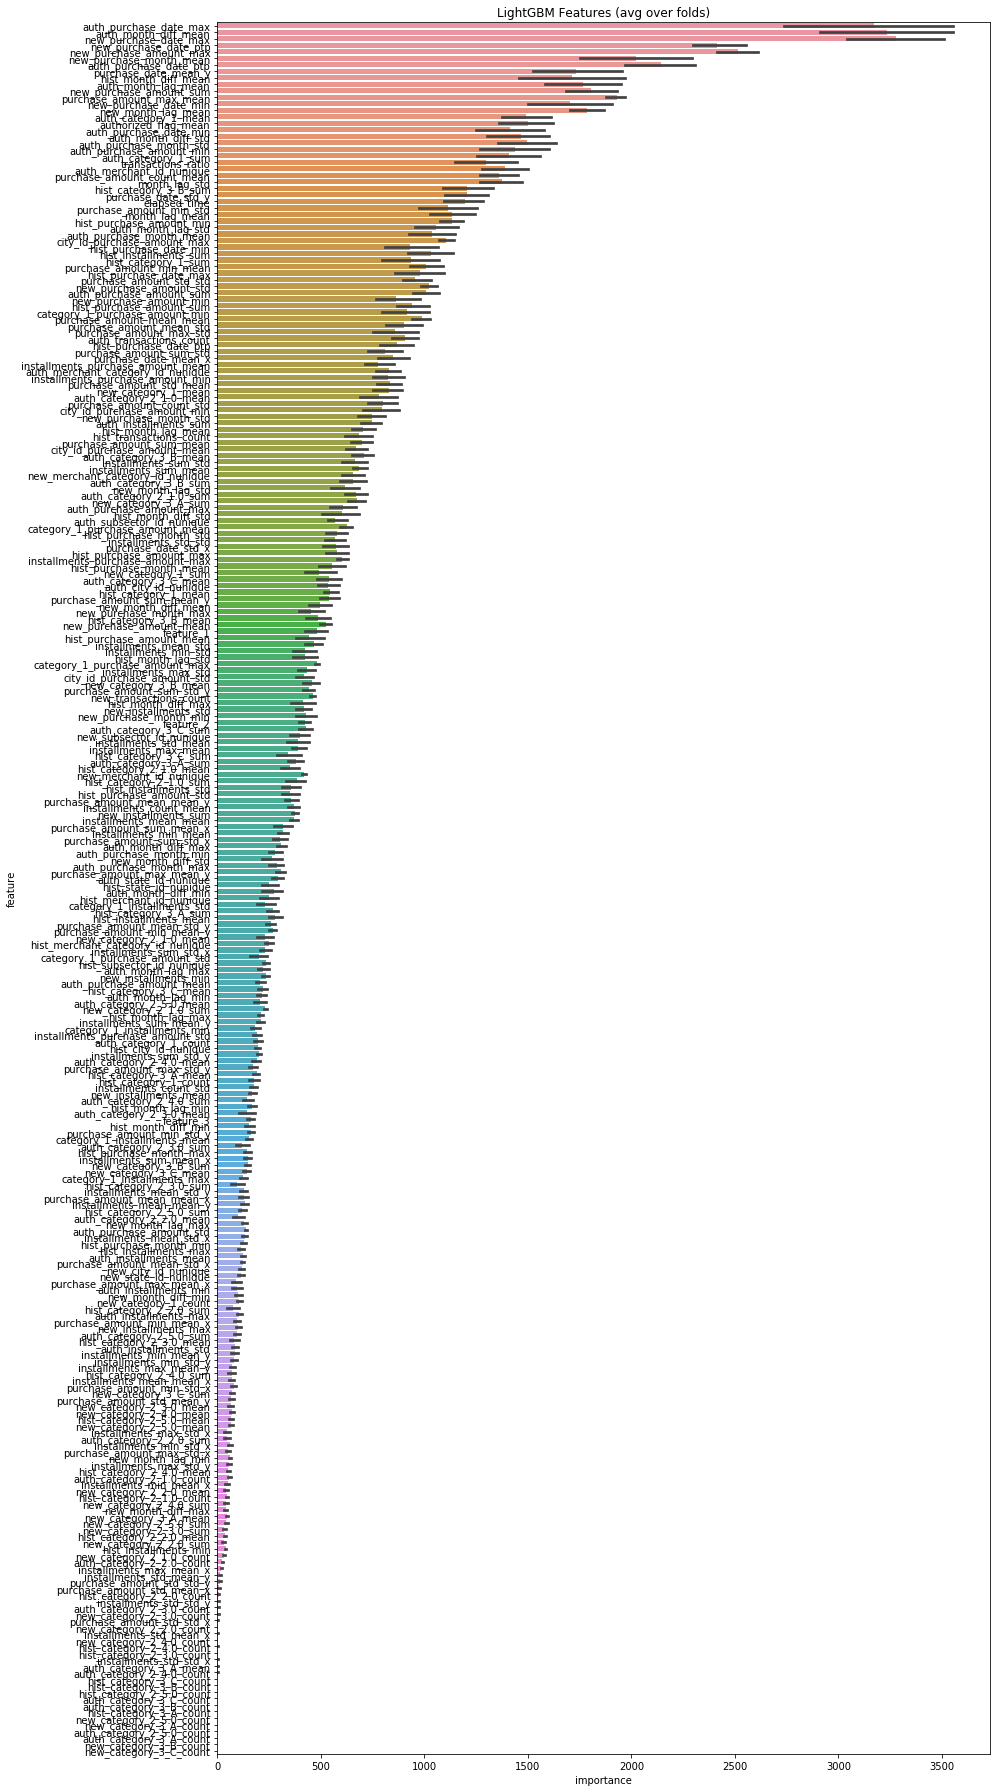

In [46]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [47]:
train_stack = np.vstack([oof_ridge, oof, oof_xgb]).transpose()
test_stack = np.vstack([predictions_ridge, predictions,predictions_xgb]).transpose()

folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof_stack = np.zeros(train_stack.shape[0])
predictions_stack = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_stack, target)):
    print("fold n°{}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values

    print("-" * 10 + "Ridge Regression" + str(fold_) + "-" * 10)
#     cb_model = CatBoostRegressor(iterations=3000, learning_rate=0.1, depth=8, l2_leaf_reg=20, bootstrap_type='Bernoulli',  eval_metric='RMSE', metric_period=50, od_type='Iter', od_wait=45, random_seed=17, allow_writing_files=False)
#     cb_model.fit(trn_data, trn_y, eval_set=(val_data, val_y), cat_features=[], use_best_model=True, verbose=True)
    clf = Ridge(alpha=100)
    clf.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf.predict(val_data)
    predictions_stack += clf.predict(test_stack) / 5


fold n°0
----------Ridge Regression0----------
fold n°1
----------Ridge Regression1----------
fold n°2
----------Ridge Regression2----------
fold n°3
----------Ridge Regression3----------
fold n°4
----------Ridge Regression4----------


In [48]:
models = [
    'CatBoost',
    'RandomForest',
    'Lasso',
    'KNN',
    'lgb',
    'ridge',
    'xgb',
    'stack']
r = [np.sqrt(mean_squared_error(oof, target)),np.sqrt(mean_squared_error(oof_ridge, target)),np.sqrt(mean_squared_error(oof_xgb, target)),np.sqrt(mean_squared_error(oof_stack, target))]
scores+= r                                                                                         
                                                                                        

In [49]:
scores

[3.6969811659519296,
 3.7001765536742264,
 3.8340295731135923,
 3.887811131274356,
 3.656887847748912,
 3.9388618135224918,
 3.6744813583810605,
 3.656407260195957]

In [50]:
df = pd.DataFrame({ 'Model': models, 'Error': scores })
df

,Model,Error
0,CatBoost,3.696981
1,RandomForest,3.700177
2,Lasso,3.834030
3,KNN,3.887811
4,lgb,3.656888
5,ridge,3.938862
6,xgb,3.674481
7,stack,3.656407


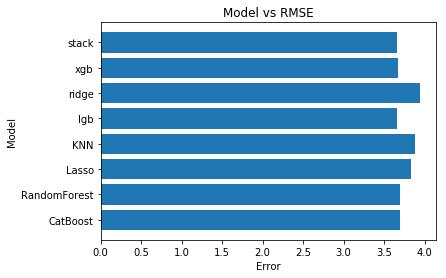

In [51]:
import pandas as pd

plt.barh(df['Model'], df['Error'])
plt.title('Model vs RMSE')
plt.ylabel('Model')
plt.xlabel('Error')
plt.show()

In [52]:
test1 = test.copy()
del test1['card_id']

In [53]:

catboost_model.fit(train.values, target.values) 
predictions_cat = catboost_model.predict(test1.values)

0:	learn: 3.8631595	total: 228ms	remaining: 27.1s
1:	learn: 3.8557821	total: 450ms	remaining: 26.6s
2:	learn: 3.8486546	total: 675ms	remaining: 26.3s
3:	learn: 3.8421753	total: 902ms	remaining: 26.2s
4:	learn: 3.8358591	total: 1.13s	remaining: 26s
5:	learn: 3.8297121	total: 1.35s	remaining: 25.6s
6:	learn: 3.8239735	total: 1.57s	remaining: 25.4s
7:	learn: 3.8185210	total: 1.82s	remaining: 25.4s
8:	learn: 3.8133803	total: 2.04s	remaining: 25.1s
9:	learn: 3.8079151	total: 2.25s	remaining: 24.7s
10:	learn: 3.8026669	total: 2.48s	remaining: 24.6s
11:	learn: 3.7980061	total: 2.69s	remaining: 24.2s
12:	learn: 3.7935398	total: 2.94s	remaining: 24.2s
13:	learn: 3.7889362	total: 3.19s	remaining: 24.1s
14:	learn: 3.7855866	total: 3.42s	remaining: 24s
15:	learn: 3.7817910	total: 3.63s	remaining: 23.6s
16:	learn: 3.7776702	total: 3.86s	remaining: 23.4s
17:	learn: 3.7743787	total: 4.11s	remaining: 23.3s
18:	learn: 3.7710653	total: 4.34s	remaining: 23.1s
19:	learn: 3.7676466	total: 4.55s	remaining: 

<a id="5"></a> <br>
## 5. Submission
Now, we just need to prepare the submission file:

In [54]:
sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submit.csv", index=False)

sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions_xgb
sub_df.to_csv("submit1.csv", index=False)

sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions_stack
sub_df.to_csv("submit2.csv", index=False)

sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions_cat
sub_df.to_csv("submit3.csv", index=False)

In [55]:
#[1050]	training's rmse: 3.47865	valid_1's rmse: 3.61203     CV score: 3.65527 